In [55]:
import easyocr
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib as mpl
import imutils
import mediapipe as mp

objc[14896]: Class CaptureDelegate is implemented in both /Users/gergelyfazekas/Documents/python_projects/ocr/ocr_venv/lib/python3.10/site-packages/cv2/cv2.cpython-310-darwin.so (0x145412398) and /Users/gergelyfazekas/Documents/python_projects/ocr/ocr_venv/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x159764860). One of the two will be used. Which one is undefined.
objc[14896]: Class CVWindow is implemented in both /Users/gergelyfazekas/Documents/python_projects/ocr/ocr_venv/lib/python3.10/site-packages/cv2/cv2.cpython-310-darwin.so (0x1454123e8) and /Users/gergelyfazekas/Documents/python_projects/ocr/ocr_venv/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x1365eca68). One of the two will be used. Which one is undefined.
objc[14896]: Class CVView is implemented in both /Users/gergelyfazekas/Documents/python_projects/ocr/ocr_venv/lib/python3.10/site-packages/cv2/cv2.cpython-310-darwin.so (0x145412410) and /Users/gergely

## Player pose detection

### Loading the image

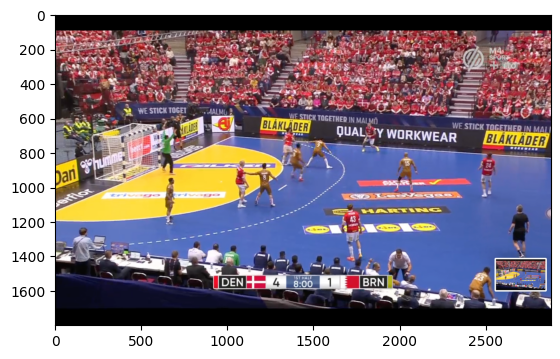

In [4]:
img_2 = cv2.imread('img_2.png')

# Convert to RGB
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

# Show
plt.imshow(img_2)

### Applying filters

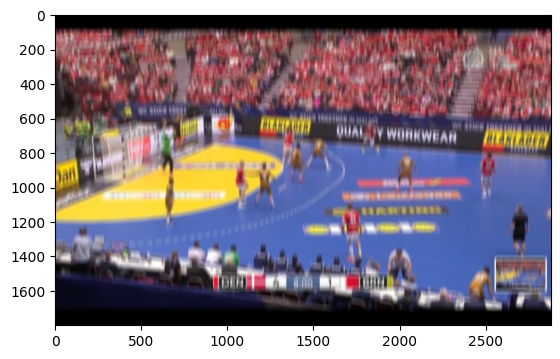

In [14]:
filtered_img = filter_img(img_2)

### Crop image to show appropriate region

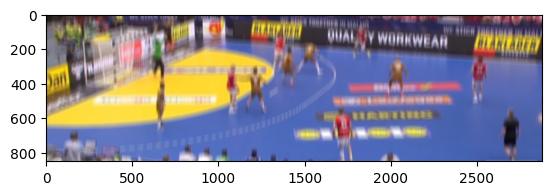

In [15]:
# Crop img to only show the court and players
cropped_img = filtered_img[550:1400,:]
plt.imshow(cropped_img)

### Change color to grayscale

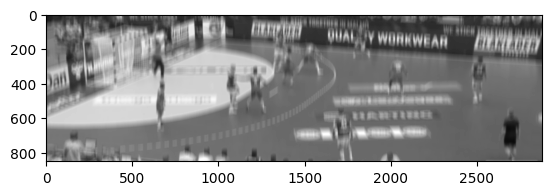

In [16]:
gray = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)

### Threshold to zero

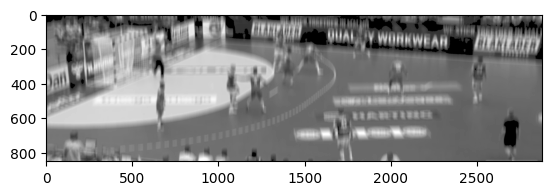

In [18]:
_, im = cv2.threshold(gray, 50, 255, cv2.THRESH_TOZERO)
plt.imshow(im, cmap='gray', vmin=0, vmax=255)

### Blob detector

(<KeyPoint 0x159718900>, <KeyPoint 0x159667420>, <KeyPoint 0x16e3d2cd0>, <KeyPoint 0x16e3d39f0>, <KeyPoint 0x16e3d33c0>, <KeyPoint 0x16e3d26d0>, <KeyPoint 0x16e3d2700>, <KeyPoint 0x16e3d2760>, <KeyPoint 0x16e3d33f0>, <KeyPoint 0x16e3d19b0>, <KeyPoint 0x16e3d22b0>, <KeyPoint 0x16e3d27c0>, <KeyPoint 0x1595f9380>, <KeyPoint 0x16e3ee0d0>, <KeyPoint 0x16e3ee910>, <KeyPoint 0x16e3eff90>, <KeyPoint 0x16e3ec780>, <KeyPoint 0x16e3ee460>, <KeyPoint 0x16e3ed2c0>, <KeyPoint 0x16e3ed260>, <KeyPoint 0x16e3ec3c0>, <KeyPoint 0x16e3ed1d0>)


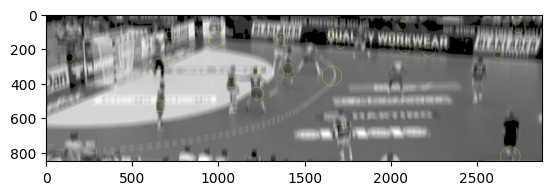

In [23]:
img_with_blobs, blobs = blob_detector(im)

In [50]:
blob = [blobs[9]]

In [51]:
goalkeeper = crop(img_2[550:1400,:], blob)

x,y,w,h 656 294 506 44


In [53]:
cv2.imwrite(r'/Users/gergelyfazekas/Documents/python_projects/ocr/goalkeeper.png', goalkeeper)

True

In [49]:
def crop(img, blobs):
    bounding_width = 300
    bounding_height = 500

    for blob in blobs:
        x,y = round(blob.pt[0]), round(blob.pt[1])
        left_coord = round(x - (0.5*bounding_width))
        bottom_coord = round(y - (0.5*bounding_height))
        print("x,y,w,h", x,y,left_coord,bottom_coord)
        
        cropped = img[bottom_coord:bottom_coord+bounding_height, left_coord:left_coord+bounding_width]
    #plt.imshow(cropped)
    return cropped

In [22]:
def blob_detector(img, show=True):

    # Set up the detector with default parameters.
    params = cv2.SimpleBlobDetector_Params()
    # Change thresholds
    params.minThreshold = 1;
    params.maxThreshold = 50000;

    # Filter by Area.
    params.filterByArea = True
    params.minArea = 800

    # Filter by Convexity
    params.filterByConvexity = False
    params.minConvexity = 0.003
    params.maxConvexity = 0.99

    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.01
    params.maxInertiaRatio = 0.4

    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(img)
    print(keypoints)

    # Draw detected blobs as red circles.
    #cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (255,255,20), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
    if show:
        plt.imshow(im_with_keypoints)
        
    return im_with_keypoints, keypoints


In [13]:
# Players are elongated shapes with consistent color so a sufficiently long kernel might help
def _long_filter(img, kernel_height = 40, kernel_width = 5):
    """applies a simple matrix of ones with shape kernel_height, kernel_width"""
    kernel = np.ones((kernel_height, kernel_width), np.float32) / (kernel_height*kernel_width)
    img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return img

# For smoothing logos, numbers and different colored shapes on players' jersey
def _hole_filter(img, N=5):
    """applies an NxN filter only the outer frame of the matrix has weights and the middle is zero
    e.g. [1,1,1]
         [1,0,1]
         [1,1,1]
    """
    kernel = np.ones((N,N), np.float32)
    kernel[1:-1, 1:-1] = np.zeros((kernel.shape[0]-2,kernel.shape[1]-2))

    kernel = kernel / ((kernel.shape[0])*(kernel.shape[1]))
    kernel[kernel>0] += (1/len(kernel[kernel>0])) * kernel[kernel>0][0]

    img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return img

def filter_img(img, mode="long", show=True, **kwargs):
    """applies a filter specified by the mode argument to the image
    args:
    img: np.array, source image to which the filter is applied
    mode: one of "long", "hole"
    
    kwargs:
    passed to the filter function specified by mode
    """
    if mode=="long":
        filtered = _long_filter(img, **kwargs)
    
    elif mode=="hole":
        filtered = _hole_filter(img, **kwargs)
        
    else:
        raise ValueError(f"Invalid argument mode={mode}")
        
    if show:
        plt.imshow(filtered)
        
    return filtered
    

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Nose coordinates: (146.84413075447083, 109.36935991048813)


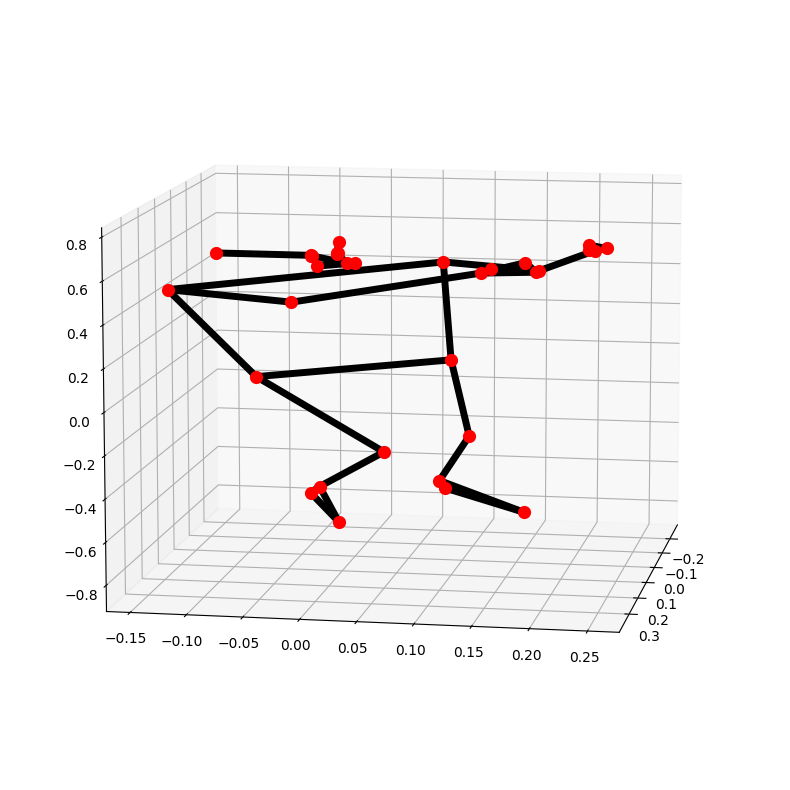

In [56]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# For static images:
IMAGE_FILES = [r'/Users/gergelyfazekas/Documents/python_projects/ocr/goalkeeper.png']
             #r'/Users/gergelyfazekas/Documents/python_projects/ocr/img_2.png',
             #r'/Users/gergelyfazekas/Documents/python_projects/ocr/img_3.png']
BG_COLOR = (192, 192, 192) # gray
with mp_pose.Pose(
    static_image_mode=True,
    model_complexity=1,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
    
    for idx, file in enumerate(IMAGE_FILES):
        image = cv2.imread(file)
        image_height, image_width, _ = image.shape
        # Convert the BGR image to RGB before processing.
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if not results.pose_landmarks:
            continue
        print(
            f'Nose coordinates: ('
            f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
            f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
        )

        annotated_image = image.copy()
        # Draw segmentation on the image.
        # To improve segmentation around boundaries, consider applying a joint
        # bilateral filter to "results.segmentation_mask" with "image".
        condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
        bg_image = np.zeros(image.shape, dtype=np.uint8)
        bg_image[:] = BG_COLOR
        annotated_image = np.where(condition, annotated_image, bg_image)
        # Draw pose landmarks on the image.
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        cv2.imwrite(r'/Users/gergelyfazekas/Documents/python_projects/ocr/annotated_image' + str(idx+1) + '.png', annotated_image)
        # Plot pose world landmarks.
        mp_drawing.plot_landmarks(
            results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

In [ ]:
keypoints[0].pt

In [2]:
reader = easyocr.Reader(['en'], gpu=True)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [5]:
result = reader.readtext(img_2)

In [6]:
hog = cv2.HOGDescriptor()  
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector()) 

In [7]:
(humans, _) = hog.detectMultiScale(img_2,
                                   hitThreshold=0.1,
                                    winStride=(5, 5), 
                                    padding=(3, 3), 
                                    scale=1.21)

In [8]:
numbers = []
for item in result:
    try:
        int(item[1])
        numbers.append(item)
    except ValueError:
        pass

height = numbers[1][0]

height = 48
width = 51
base = (1703,1159)

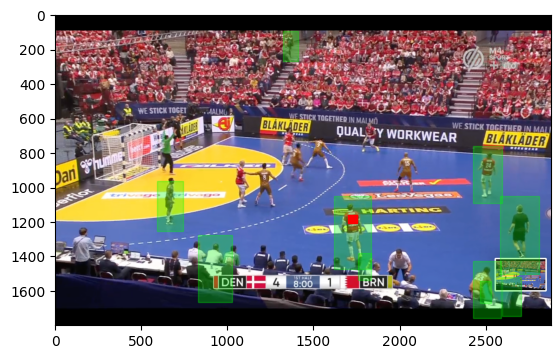

In [9]:
fig, ax = plt.subplots()
ax.imshow(img_2)
rect = mpl.patches.Rectangle(base, width, height, color=(1,0,0))
for player in humans:
    rect_player = mpl.patches.Rectangle((player[0], player[1]), player[2], player[3], color=(0,1,0, 0.3))
    ax.add_patch(rect_player)
ax.add_patch(rect)

In [ ]:
x,y,w,h = humans[1]

cropped = img_2[y:y+h, x:x+w]
print(x,y,w,h)
plt.imshow(cropped)

In [ ]:
img_2.shape